# AI model training: can a machine differenciate questions/non-questions (binary classification) with textual and audio content?
1. Load the dataset

In [6]:
import pandas as pd
import ast
import os

if os.path.exists("N_1000_filtered_train_data_with_features.csv"):
    filename = "N_1000_filtered_train_data_with_features.csv"
else:
    filename = "example_files/N_1000_filtered_train_data_with_features.csv"
	
# Load full dataset
df = pd.read_csv(filename)

# Define labels that are questions
question_labels = {'yn', 'wh', 'imp'}

# Sample with all columns preserved
yn_df = df[df['label'] == 'yn']
wh_df = df[df['label'] == 'wh'].sample(n=min(100, len(df[df['label'] == 'wh'])), random_state=42)
imp_df = df[df['label'] == 'imp'].sample(n=min(100, len(df[df['label'] == 'imp'])), random_state=42)
nq_df = df[df['label'] == 'nq'].sample(n=295, random_state=42)

# Combine them
balanced_df = pd.concat([yn_df, wh_df, imp_df, nq_df])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Assign binary label: question (1) vs. not-question (0)
balanced_df['binary_label'] = balanced_df['label'].apply(lambda x: 1 if x in question_labels else 0)

# Parse MFCCs
balanced_df['mfcc_means'] = balanced_df['mfcc_means'].apply(ast.literal_eval)

# Check counts
print(balanced_df['binary_label'].value_counts())

binary_label
0    295
1    295
Name: count, dtype: int64


2. Organize all data to prepare for AI training (only text)

In [9]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import sparse

# Vectorize text
vectorizer = TfidfVectorizer()
text_features = vectorizer.fit_transform(balanced_df['text'])

# Extract dense acoustic features
numeric_features = balanced_df[[
    'word_count', 'f0_mean', 'f0_std', 'f0_end_slope',
    'energy_mean', 'energy_std', 'zcr_mean'
]].values

mfcc_features = np.array(balanced_df['mfcc_means'].tolist())

# Combine numeric + MFCCs
dense_features = np.hstack([numeric_features, mfcc_features])

# Scale the dense features (insert this here!)
scaler = StandardScaler()
scaled_dense = scaler.fit_transform(dense_features)

# Convert scaled dense to sparse, and combine with text
dense_sparse = sparse.csr_matrix(scaled_dense)
#X = hstack([text_features, dense_sparse])
X = text_features

# Labels
y = balanced_df['binary_label']

3.1 Model training and visulization(Logistical regression)

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87        59
           1       0.84      0.92      0.88        59

    accuracy                           0.87       118
   macro avg       0.88      0.87      0.87       118
weighted avg       0.88      0.87      0.87       118

Confusion Matrix:
 [[49 10]
 [ 5 54]]


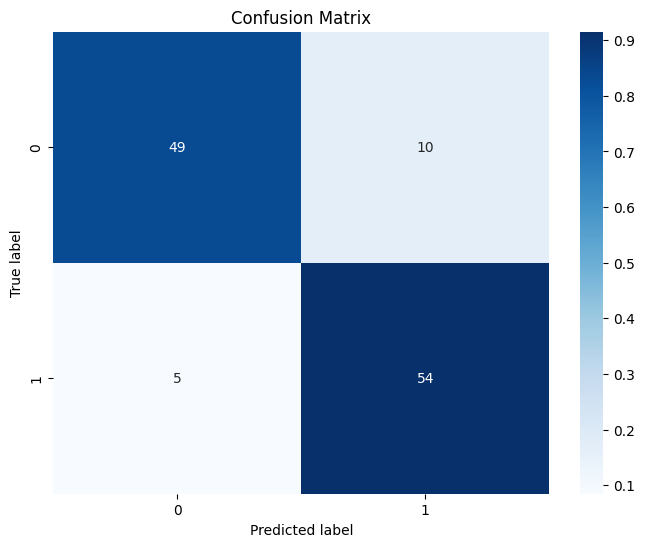

In [10]:
# Train a Classifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=777, stratify=y
)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Train the model
clf = LogisticRegression(max_iter=5000)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


# Use seaborn for visualization
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the raw confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize it so each row sums to 1 (color)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 3. Plot
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,               # or cm if you want counts
    annot=cm,              # show raw counts in the boxes
    fmt='d',               # integer format for counts
    cmap='Blues',          # choose a colormap you like
    xticklabels=clf.classes_,
    yticklabels=clf.classes_
)
plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

3.2 Model training and visulization(SVM)

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89        59
           1       0.88      0.90      0.89        59

    accuracy                           0.89       118
   macro avg       0.89      0.89      0.89       118
weighted avg       0.89      0.89      0.89       118

Confusion Matrix:
 [[52  7]
 [ 6 53]]


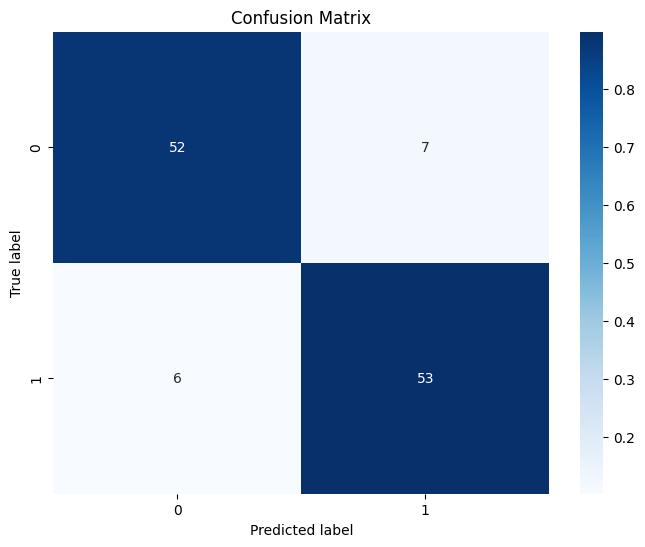

In [11]:
from sklearn.svm import LinearSVC 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=777, stratify=y
)

# Train the SVM model
clf = LinearSVC(max_iter=5000)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


# Compute the raw confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize it so each row sums to 1 (color)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 3. Plot
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,               # or cm if you want counts
    annot=cm,              # show raw counts in the boxes
    fmt='d',               # integer format for counts
    cmap='Blues',          # choose a colormap you like
    xticklabels=clf.classes_,
    yticklabels=clf.classes_
)
plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()


4.1 Perform a 7-fold cross validation (LogisticRegression)

Fold 1 Confusion Matrix:
[[38  5]
 [ 9 33]]

Fold 1 Accuracy: 0.8353
Fold 1 Recall (macro): 0.8347

Fold 2 Confusion Matrix:
[[37  5]
 [ 5 38]]

Fold 2 Accuracy: 0.8824
Fold 2 Recall (macro): 0.8823

Fold 3 Confusion Matrix:
[[37  5]
 [ 5 37]]

Fold 3 Accuracy: 0.8810
Fold 3 Recall (macro): 0.8810

Fold 4 Confusion Matrix:
[[40  2]
 [ 3 39]]

Fold 4 Accuracy: 0.9405
Fold 4 Recall (macro): 0.9405

Fold 5 Confusion Matrix:
[[40  2]
 [10 32]]

Fold 5 Accuracy: 0.8571
Fold 5 Recall (macro): 0.8571

Fold 6 Confusion Matrix:
[[36  6]
 [ 4 38]]

Fold 6 Accuracy: 0.8810
Fold 6 Recall (macro): 0.8810

Fold 7 Confusion Matrix:
[[36  6]
 [ 8 34]]

Fold 7 Accuracy: 0.8333
Fold 7 Recall (macro): 0.8333

Average Confusion Matrix:
 [[37.71428571  4.42857143]
 [ 6.28571429 35.85714286]]
Average Accuracy: 0.8729
Average Recall (macro): 0.8728


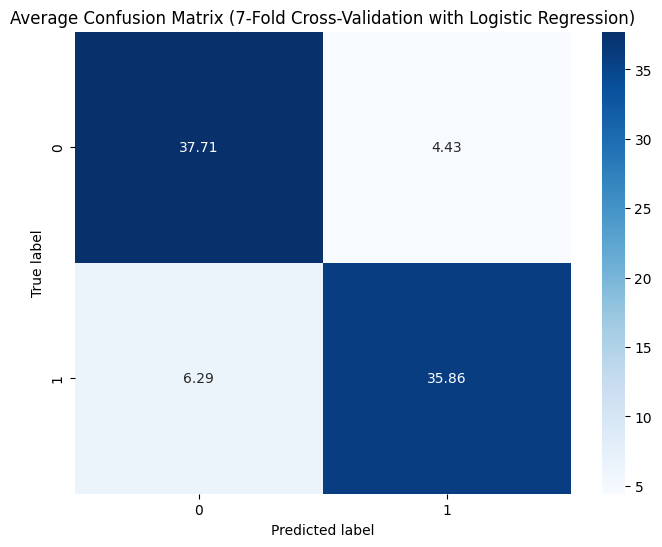

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.model_selection import StratifiedKFold

# Define the number of folds
n_splits = 7
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

# Lists to store confusion matrices and metrics for each fold
conf_mats = []
accuracy_scores = []
recall_scores = []

# Iterate over each fold
for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    # Split the data into training and validation sets
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize and train the Logistic Regression model
    clf = LogisticRegression(max_iter=5000)
    clf.fit(X_train, y_train)
    
    # Make predictions on the validation fold
    y_pred = clf.predict(X_val)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    conf_mats.append(cm)
    
    # Compute accuracy and recall for the current fold
    acc = accuracy_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred, average='macro')  # macro average computes recall for each class and takes the unweighted mean
    accuracy_scores.append(acc)
    recall_scores.append(rec)
    
    # Print fold-specific results
    print(f"Fold {fold} Confusion Matrix:\n{cm}\n")
    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print(f"Fold {fold} Recall (macro): {rec:.4f}\n")

# Compute the average confusion matrix, accuracy, and recall across all folds
avg_cm = np.mean(conf_mats, axis=0)
avg_accuracy = np.mean(accuracy_scores)
avg_recall = np.mean(recall_scores)

print("Average Confusion Matrix:\n", avg_cm)
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Recall (macro): {avg_recall:.4f}")

# Plot the average confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(
    avg_cm, 
    annot=True, 
    fmt=".2f",  # Format floats with 2 decimal places
    cmap="Blues",
    xticklabels=clf.classes_,
    yticklabels=clf.classes_
)
plt.title("Average Confusion Matrix (7-Fold Cross-Validation with Logistic Regression)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()



4.2 Perform a 7-fold cross validation (SVM)

Fold 1 Confusion Matrix:
[[40  3]
 [ 6 36]]

Fold 1 Accuracy: 0.8941
Fold 1 Recall (macro): 0.8937

Fold 2 Confusion Matrix:
[[42  0]
 [ 8 35]]

Fold 2 Accuracy: 0.9059
Fold 2 Recall (macro): 0.9070

Fold 3 Confusion Matrix:
[[40  2]
 [ 7 35]]

Fold 3 Accuracy: 0.8929
Fold 3 Recall (macro): 0.8929

Fold 4 Confusion Matrix:
[[39  3]
 [ 6 36]]

Fold 4 Accuracy: 0.8929
Fold 4 Recall (macro): 0.8929

Fold 5 Confusion Matrix:
[[36  6]
 [ 5 37]]

Fold 5 Accuracy: 0.8690
Fold 5 Recall (macro): 0.8690

Fold 6 Confusion Matrix:
[[39  3]
 [ 1 41]]

Fold 6 Accuracy: 0.9524
Fold 6 Recall (macro): 0.9524

Fold 7 Confusion Matrix:
[[32 10]
 [ 2 40]]

Fold 7 Accuracy: 0.8571
Fold 7 Recall (macro): 0.8571

Average Confusion Matrix:
 [[38.28571429  3.85714286]
 [ 5.         37.14285714]]
Average Accuracy: 0.8949
Average Recall (macro): 0.8950


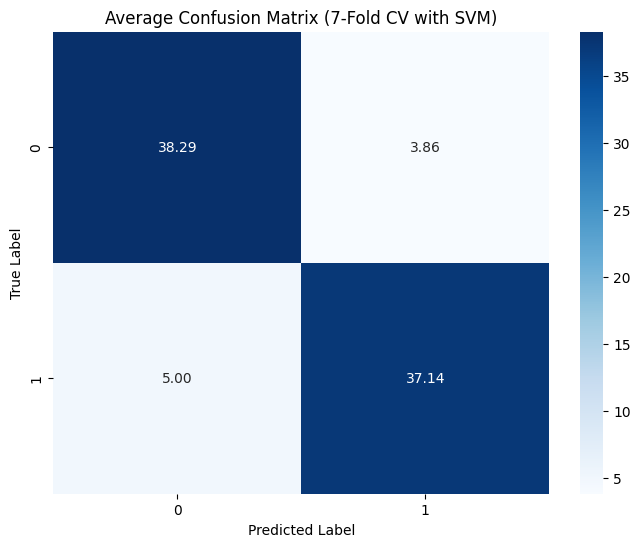

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score
from sklearn.model_selection import StratifiedKFold

# Define the number of folds for cross-validation
n_splits = 7
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

# List to store confusion matrices for each fold
conf_mats = []
accuracy_scores = []
recall_scores = []


# Iterate over each fold
for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    # Split the data into training and validation sets.
    # Note: If X is a sparse matrix and y is a Pandas Series, we adjust indexing accordingly.
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize and train the SVM model. Using a linear kernel as an example.
    svm_model = SVC(kernel='linear', probability=True)
    svm_model.fit(X_train, y_train)
    
    # Make predictions on the validation fold
    y_pred = svm_model.predict(X_val)
    
    # Compute the confusion matrix for this fold and store it
    cm = confusion_matrix(y_val, y_pred)
    conf_mats.append(cm)
    
    # Compute accuracy and recall for this fold
    acc = accuracy_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred, average='macro')  # Using macro-average for recall
    accuracy_scores.append(acc)
    recall_scores.append(rec)
    
    # Print fold-specific results
    print(f"Fold {fold} Confusion Matrix:\n{cm}\n")
    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print(f"Fold {fold} Recall (macro): {rec:.4f}\n")

# Compute the average confusion matrix across all folds
avg_cm = np.mean(conf_mats, axis=0)
avg_accuracy = np.mean(accuracy_scores)
avg_recall = np.mean(recall_scores)

print("Average Confusion Matrix:\n", avg_cm)
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Recall (macro): {avg_recall:.4f}")

# Plot the average confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(
    avg_cm, 
    annot=True, 
    fmt=".2f",  # Display floats with 2 decimal places
    cmap="Blues",
    xticklabels=svm_model.classes_,
    yticklabels=svm_model.classes_
)
plt.title("Average Confusion Matrix (7-Fold CV with SVM)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()




## Determine if using prosodic features improves classification accuracy

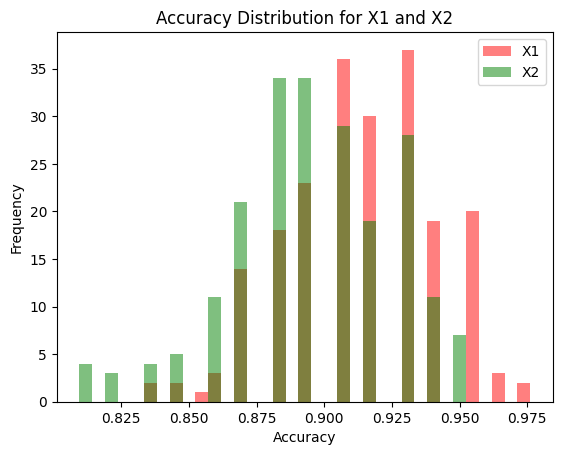

Paired t-test over 210 evaluations:
  t = 8.7121, p = 0.0000000000
  Mean Acc X1 = 0.9124, X2 = 0.8952


In [14]:
from sklearn.model_selection import StratifiedKFold
from scipy.stats import ttest_rel

X1 = hstack([text_features, dense_sparse])
X2 = text_features

# Number of repetitions and CV folds
n_repeats = 30
n_splits = 7

acc_X1_all = []
acc_X2_all = []

for repeat in range(n_repeats):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=repeat)
    
    acc_X1 = []
    acc_X2 = []
    
    for train_index, test_index in skf.split(X1, y):
        X1_train, X1_val = X1[train_index], X1[test_index]
        X2_train, X2_val = X2[train_index], X2[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]

        # SVM on X1
        svm_X1 = SVC(kernel='linear')
        svm_X1.fit(X1_train, y_train)
        y_pred_X1 = svm_X1.predict(X1_val)
        acc_X1.append(accuracy_score(y_val, y_pred_X1))

        # SVM on X2
        svm_X2 = SVC(kernel='linear')
        svm_X2.fit(X2_train, y_train)
        y_pred_X2 = svm_X2.predict(X2_val)
        acc_X2.append(accuracy_score(y_val, y_pred_X2))
    
    acc_X1_all.extend(acc_X1)
    acc_X2_all.extend(acc_X2)

# Convert to numpy arrays
acc_X1_all = np.array(acc_X1_all)
acc_X2_all = np.array(acc_X2_all)

plt.hist(acc_X1_all, bins=30, alpha=0.5, label='X1', color='red')
plt.hist(acc_X2_all, bins=30, alpha=0.5, label='X2', color='green')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Accuracy Distribution for X1 and X2')
plt.legend()
plt.show()

# Paired t-test
t_stat, p_val = ttest_rel(acc_X1_all, acc_X2_all)
print(f"Paired t-test over {n_repeats * n_splits} evaluations:")
print(f"  t = {t_stat:.4f}, p = {p_val:.10f}")
print(f"  Mean Acc X1 = {acc_X1_all.mean():.4f}, X2 = {acc_X2_all.mean():.4f}")
